In [5]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Loading Image data

In [6]:
def verify_image(img_file):
    '''
    Testing the corrupted images.
    '''
    try:
        v_image = Image.open(img_file)
        v_image.verify()
        return True
    except OSError:
        return False

In [7]:

def Load_image_data(rootdir = ''):
    images =[]
    labels = []
    test_images = []
    test_labels = []
    for dirname, _, filenames in os.walk(rootdir):
        if dirname.split('/')[-2] =='test':
            # images are testing image
            for filename in filenames:
                    test_images.append(os.path.join(dirname,filename))
                    test_labels.append(dirname.split('/')[-1])
        else:
            # images are training image
            for filename in filenames:
                    images.append(os.path.join(dirname,filename))
                    labels.append(dirname.split('/')[-1])
                
    return images,labels,test_images,test_labels

In [8]:
rootdir = "/kaggle/input/cifar10/cifar10"
i,l,ti,tl = Load_image_data(rootdir)

# Pre-Processing

In [9]:
train_df = pd.DataFrame(data={"image":i, "label": l})

test_df = pd.DataFrame(data={"image":ti,"label":tl})

In [10]:
print(train_df['label'].unique())
train_df.shape

['airplane' 'horse' 'truck' 'automobile' 'ship' 'dog' 'bird' 'frog' 'cat'
 'deer']


(50000, 2)

In [11]:
train_df['label']=train_df['label'].map({'airplane':0, 'horse':1, 'truck':2, 'automobile':3, 'ship':4, 'dog':5, 'bird':6,
       'frog':7, 'cat':8, 'deer':9})

In [12]:
test_df['label'] = test_df['label'].map({'airplane':0, 'horse':1, 'truck':2, 'automobile':3, 'ship':4, 'dog':5, 'bird':6,
       'frog':7, 'cat':8, 'deer':9})

In [13]:
print(train_df['label'].unique())
print(test_df['label'].unique())

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [14]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [15]:
train_df.head()

,image,label
0,/kaggle/input/cifar10/cifar10/train/frog/1687.png,7
1,/kaggle/input/cifar10/cifar10/train/horse/4527...,1
2,/kaggle/input/cifar10/cifar10/train/bird/3868.png,6
3,/kaggle/input/cifar10/cifar10/train/ship/1844.png,4
4,/kaggle/input/cifar10/cifar10/train/frog/2384.png,7


# Array of Image

In [16]:
train = []
for i in range(len(train_df)):
    im = cv2.imread(train_df.iloc[i][0])
#     print(train_df.iloc[i][0])
#     print(train_df.iloc[i][1])
    train.append((im,train_df.iloc[i][1]))
   

In [17]:
def visualize_images(imagelist):
    plt.figure(figsize=(20,10))
    
    for i in range(50):
        plt.subplot(5,10,i+1)
        idx = np.random.randint(0,10000)
        plt.imshow(imagelist[idx][0])
        plt.xlabel(imagelist[idx][1])
        plt.xticks([])
        plt.yticks([])
    plt.show()

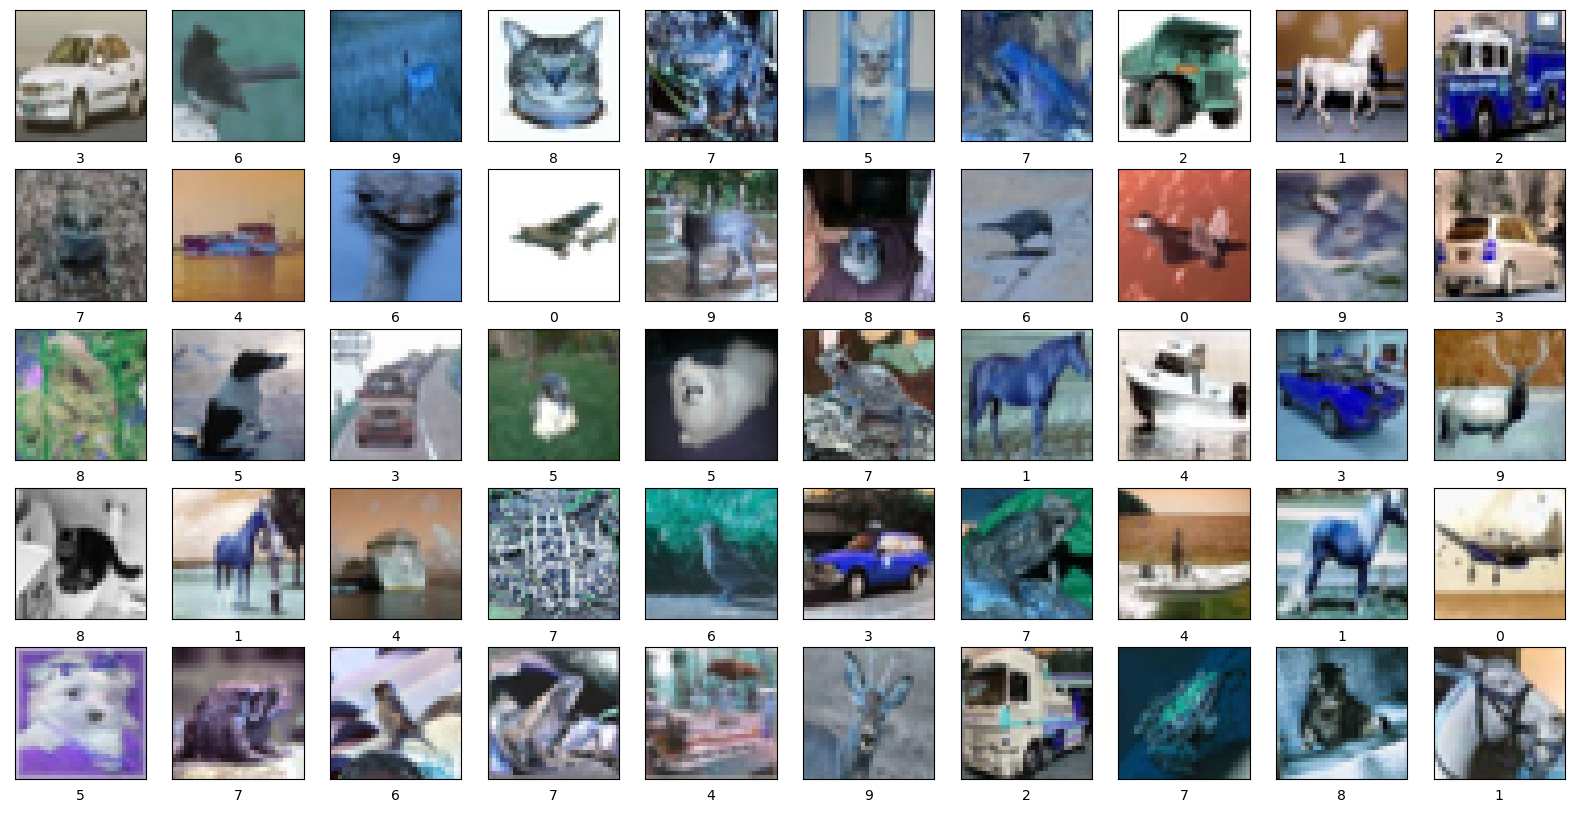

In [18]:
visualize_images(train)

## Creating the folds of data

In [28]:
f0 = train[0:1000]
f1 = train[1000:2000]
f2 = train[2000:3000]
f3 = train[3000:4000]
f4 = train[4000:5000]

# Neighters Neiboure class

In [20]:
class NearestNeighbour:
    
    def __init__(self,k,distancemetric="l2"):
        self.K = k
        self.trainSet = None
        self.distanceMetric = distancemetric.lower()
        
    def fit(self,train):
        """
        A list of all the images numaric value(nd-Numpy array) tuppled up with it's label.
        """
        self.trainSet = train
        
    # L1 distance calculator
    def __L1_distance(self,train_img,test_img):
        dis = np.sum(np.abs(train_img - test_img))
        return dis

    # L2 distance calculator
    def __L2_distance(self, train_img,test_img):
        """
        take input of two numpy array. 
        first one is know and second is unknow/checking array value.
        more about L2 distance
        https://en.wikipedia.org/wiki/Euclidean_distance
        d = √[(x2 – x1)2 + (y2 – y1)2]
        np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
        """
        temp = train_img - test_img
        dis = np.sqrt(np.sum(np.square(temp)))
        return dis
    
    # function to calculate the distance as the given distace matric
    def __distanceCalculator(self,validatingSet):
        accuracy = 0
        for vidx in range(len(validatingSet)):
            distnaceList = []
            cnt = 0
            for tidx in range(len(self.trainSet)):
                d = 0
                if self.distanceMetric == 'l1':
                    d = self.__L1_distance(self.trainSet[tidx][0],validatingSet[vidx][0])
                else:
                    d = self.__L2_distance(self.trainSet[tidx][0],validatingSet[vidx][0])
                distnaceList.append((d,self.trainSet[tidx][1]))
            # sorting the distance array base on first value to tupple
            distnaceList.sort(key=(lambda a: a[0]))
            labels = [v[1] for v in distnaceList[:self.K]]
            label = max(set(labels), key = labels.count)
            
            if label == validatingSet[vidx][1]:
                cnt+=1
            
            accuracy += cnt
            
        return accuracy, (accuracy/len(validatingSet))
    
    # predict function
    def predict(self,validatingSet):
        """
        Function to prdict the unseen or test data
        Takes a list of test image(nd-numpy array) tuppled with it's label
        
        `Return`: a tuple of count of accuratrly classified instances and accuracy
        """
        return self.__distanceCalculator(validatingSet)
    

In [21]:
def plot_Accuracies(fold,k_choices,accuracies):
    best = [0,0]
    for k in k_choices:
        accu = accuracies[k]
        if best[1]< max(accu):
            best[0]=k
            best[1]=max(accu)
        plt.scatter([k] * len(accu), accu)

    # plot the trend line with error bars that correspond to standard deviation

    accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracies.items())])
    accuracies_std = np.array([np.std(v) for k,v in sorted(accuracies.items())])
    plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
    plt.title(f"Cross-validation on fold={fold} with best K={best[0]} Accuracy = {best[1]}")
    plt.xlabel('k')
    plt.ylabel('Cross-validation accuracy')
    plt.show()

In [22]:
k_choices = [3, 5, 8, 10, 12, 15, 20, 50, 100]

# Implementing the KNN image classification with L1 distance matric

In [29]:
accuracis = {}
nfolds = 5
# creating the dictonary of k with empty list
for k in k_choices:
    accuracis[k]=[]
    
for i in range(nfolds):
    if i==0:
        trainSet = f1+f2+f3+f4
        validatingSet = f0            
    elif i==1:
        trainSet = f0+f2+f3+f4
        validatingSet = f1
    elif i==2:
        trainSet = f1+f0+f3+f4
        validatingSet = f2
    elif i==3:
        trainSet = f1+f2+f0+f4
        validatingSet = f3
    elif i==4:
        trainSet = f1+f2+f3+f0
        validatingSet = f4

    for k in k_choices:

        classifier = NearestNeighbour(k,'l1')
        classifier.fit(trainSet)
        cnt, acc = classifier.predict(validatingSet)

        accuracis[k].append(acc)

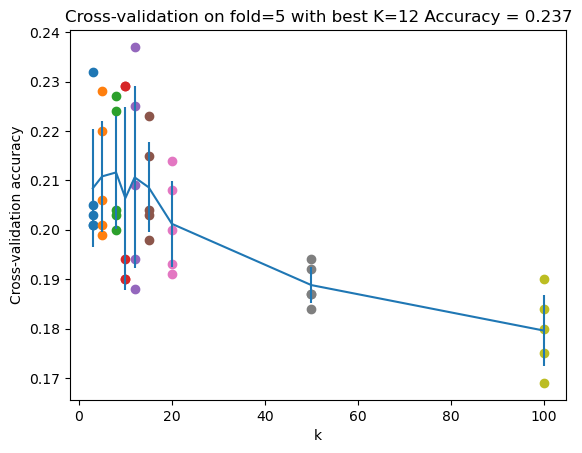

In [30]:
plot_Accuracies(5,k_choices,accuracis)

# Implementing the KNN image classification with L2 distance matric

In [31]:
accuracis = {}
nfolds = 5
# creating the dictonary of k with empty list
for k in k_choices:
    accuracis[k]=[]
    
for i in range(nfolds):
    if i==0:
        trainSet = f1+f2+f3+f4
        validatingSet = f0            
    elif i==1:
        trainSet = f0+f2+f3+f4
        validatingSet = f1
    elif i==2:
        trainSet = f1+f0+f3+f4
        validatingSet = f2
    elif i==3:
        trainSet = f1+f2+f0+f4
        validatingSet = f3
    elif i==4:
        trainSet = f1+f2+f3+f0
        validatingSet = f4

    for k in k_choices:

        classifier = NearestNeighbour(k,'l2')
        classifier.fit(trainSet)
        cnt, acc = classifier.predict(validatingSet)

        accuracis[k].append(acc)

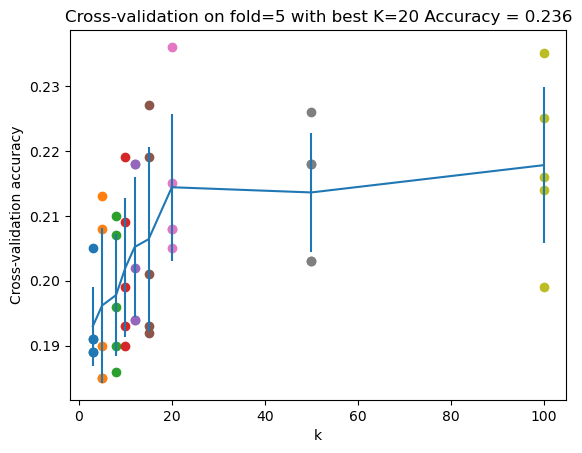

In [32]:
plot_Accuracies(5,k_choices,accuracis)

# Summary

<img src="../../others/images/knn.gif" width="100%" align="center">

Cifar10 is a well-known dataset composed of 60,000 colored 32x32 images: 50,000 as a training set and 10,000 as a test set.
Nearest Neighbor is a machine learning algorithm that compares the training data based on their similarities to a training set accompanied with labels. This algorithm is mostly referred to as "k-nearest neighbor, where "k" refers to the number of neighbors that will be compared to predict the unknown data.

Image classification using KNN is a method of classifying images in the Cifar10 dataset using the K-Nearest Neighbor algorithm. Where the distance between all the training images and the predicted label is calculated by the most closely related training image label,

The complete process of the image classification is implemented by considering both distance matrices L1 and L2 when calculating the distances of images. The total of 50,000 images are scattered within the 5 folds of the list for cross-validation and choosing the best value of k (the number of neighbors to consider).

After implementing the KNN image classifier for the Cifar10 image set, the maximum accuracy using L1 (Manhattan distance) was 22.9%, taking the "8" neighbor voting, and using L2 (Euclidian distance) was 22.9% for 100 values of k.

Conceptually, the implementation of this classifier was simple and straightforward. Which was it that we have to compare the unknown label image with all known images, among them the most accurate label image? But there are some drawbacks to the algorithm. Those are

Repetitive task: The test image will be compared with all the test images, and distance will be calculated. This process took far too long for the algorithm to be developed. This means that in real-life implementation, getting the result or prediction will take too much time. This is not reliable to deploy and use in production. We always want the minimal time to get the predicted result.

Low accuracy: In the algorithm, pixel by pixel is calculated. In a scenario where the same object has a different background or view point, the algorithm might miss the object and consider the background due to the high number of pixels, leading to a missed classification of the data.

Overall, the implementation is a good improvement in image classification. Also, this algorithm shows the importance of deep learning for classifying the images. Where the training time of the model might take a long time (depending on the problem and datasets), the actual testing time is quick to get the prediction.
